# Podcast Analytics

The tool used in this notebook, Bedrock Data Automation, provides the following rich features for audio data processing: Audio metadata (including speaker counts), Audio summarization, Full transcript with speaker identification, Chapter segmentation, and Content moderation results. Its out of box audio summarization will help to provide future knowledge base application. By the end, you will have a clear understanding of how to handle audio content end-to-end, preparing it for tasks such as topic modeling, question answering, or even generating summaries for quick reference.

## Prerequisits
You need to have suitable IAM role permission to run this notebook. For IAM role, choose either an existing IAM role in your account or create a new role. The role must the necessary permissions to invoke the BDA, SageMaker and S3 APIs.

These IAM policies can be assigned to the role: AmazonBedrockFullAccess, AmazonS3FullAccess, AmazonSageMakerFullAccess, IAMReadOnlyAccess

Note: The AdministratorAccess IAM policy can be used, if allowed by security policies at your organization.

## Note

It is important to run the cells below in order. If you need to re-start the workbook, and have not sucessfully run step 8 to cleanup resources, you will need to login to the AWS Console and delete the project and blueprints created in this workbook. 

If you get out of order, and unexpected results, you can 'Restart Kernel' from the SageMaker studio Kernel menu. 

## Setup notebook and boto3 clients

In this step, we will import some necessary libraries that will be used throughout this notebook. 
To use Amazon Bedrock Data Automation (BDA) with boto3, you'll need to ensure you have the latest version of the AWS SDK for Python (boto3) installed. Version Boto3 1.35.96 of later is required. 

Note: At time of Public Preview launch, BDA is available in us-west-2 only. 

In [ ]:
!pip install boto3==1.35.87 --upgrade

In this workshop, a default S3 bucket will be used, and the input and output will be saved under a folder called "bda" in the default bucket. 

In [ ]:
import boto3, json, uuid
from time import sleep
from IPython.display import JSON, IFrame, Audio, display
import sagemaker

session = sagemaker.Session()
default_bucket = session.default_bucket()
print(f"Bucket_name: {default_bucket}")

region_name = "us-west-2" # can be removed ones BDA is GA and available in other regions.

s3 = boto3.client('s3', region_name=region_name)
bda_client = boto3.client('bedrock-data-automation', region_name=region_name)
bda_runtime_client = boto3.client('bedrock-data-automation-runtime', region_name=region_name)

## Create a BDA project
To start a BDA job, you need a BDA project, which organizes both standard and custom output configurations. This project is reusable, allowing you to apply the same configuration to process multiple videos that share the same settings.

In the code snippet below, we create a BDA project with standard output configurations for audio modality. These configurations can be tailored to extract only the specific information you need. In this lab, we will enable the below video outputs:
- Full audio summary
- Chapter segmentation/summary
- Transcript
- Content moderation (audio)
- metadata
- Statistics

For a complete API reference for creating a BDA project, refer to this [document](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-data-automation/client/create_data_automation_project.html).

In [3]:
project_name= f'bda-workshop-audio-project-{str(uuid.uuid4())[0:4]}'

# delete project if it already exists
projects_existing = [project for project in bda_client.list_data_automation_projects()["projects"] if project["projectName"] == project_name]
if len(projects_existing) >0:
    print(f"Deleting existing project: {projects_existing[0]}")
    bda_client.delete_data_automation_project(projectArn=projects_existing[0]["projectArn"])

In [4]:
response = bda_client.create_data_automation_project(
    projectName = project_name,
    projectDescription='BDA workshop audio sample project',
    projectStage='DEVELOPMENT',
    standardOutputConfiguration={
      "audio": {
    "extraction": {
      "category": {
        "state": "ENABLED", 
        "types": ["AUDIO_CONTENT_MODERATION", "CHAPTER_CONTENT_MODERATION", "TRANSCRIPT"]
      }
    },
    "generativeField": {
      "state": "ENABLED",
      "types": ["AUDIO_SUMMARY", "CHAPTER_SUMMARY", "IAB"]
    }
  }
 }
)

The `create_data_automation_project` API will return the project ARN, which we will use it to invoke the audio analysis task.

In [5]:
audio_project_arn = response.get("projectArn")
print("BDA audio project ARN:", audio_project_arn)

BDA audio project ARN: arn:aws:bedrock:us-west-2:593512547852:data-automation-project/1265047b26c8


## Start an asynchronous BDA task to extract and analyze a audio file from podcast
In this section, we will use a sample podcast audio, and extract and analyze it using BDA, applying the configuration defined in the BDA project. 

### Download and store a sample audio
we use the document path to download the document and store it a S3 location.

In [ ]:
file_name = 'podcastdemo.mp3'
source_url = f'https://d1xvhy22zmw77y.cloudfront.net/tmp/{local_file_name}'

!curl {source_url} --output {local_file_name}

In [ ]:
# Upload an audio file
from IPython.display import Audio, display

object_name = f'bda/input/{file_name}'

default_bucket
s3.upload_file(file_name, default_bucket, object_name)

Let's display the audio. This short sample contains a short audio about a customer call. Our mission is to extract and summarize this call so the audio file can be accurately represented with text information, related with the call summary and speaker information.

In [ ]:
# Load and play an MP3 file
display(Audio(file_name, autoplay=True))

### Start BDA task
We will now invoke the BDA API to process the uploaded audio. You need to provide the BDA project ARN that we created at the beginning of the lab and specify an S3 location where BDA will store the output results.

For a complete API reference for invoke a BDA async task, refer to this [document](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-data-automation-runtime/client/invoke_data_automation_async.html).

In [ ]:
output_name = f'bda/output/' 
response = bda_runtime_client.invoke_data_automation_async(
    inputConfiguration={'s3Uri':  f"s3://{default_bucket}/{object_name}"},
    outputConfiguration={'s3Uri': f"s3://{default_bucket}/{output_name}"},
    dataAutomationConfiguration={
        'dataAutomationArn': audio_project_arn,
        'stage': 'DEVELOPMENT'
    })
response

The `invoke_data_automation_async` API is asynchronous. It returns an invocation task identifier, `invocationArn`. We can then use another API `get_data_automation_status` to monitor the task's status until it completes.

> In production workloads, an event-driven pattern is recommended. Allow BDA to trigger the next step once the task is complete. This can be achieved by configuring the notificationConfiguration in the invoke task, which will send a notification to a subscribed AWS service, such as a Lambda function. Alternatively, you can set up an S3 trigger on the bucket where BDA will drop the results.

In [10]:
invocation_arn = response.get("invocationArn")
print("BDA task started:", invocation_arn)

BDA task started: arn:aws:bedrock:us-west-2:593512547852:data-automation-invocation/6746c0d9-b7c2-4347-aa3e-02c8e77d2fac


In this lab, we will use the loop below to monitor the task by calling the `get_data_automation_status` API every 5 seconds until the task is complete.

This video will take less than 5 minutes to process.

In [ ]:
import time
from IPython.display import clear_output
from datetime import datetime

status, status_response = None, None
while status not in ["Success","ServiceError","ClientError"]:
    status_response = bda_runtime_client.get_data_automation_status(
        invocationArn=invocation_arn
    )
    status = status_response.get("status")
    clear_output(wait=True)
    print(f"{datetime.now().strftime('%H:%M:%S')} : BDA audio task: {status}")
    time.sleep(5)

output_config = status_response.get("outputConfiguration",{}).get("s3Uri")
print("Ouput configureation file:", output_config)

## Access the BDA analysis result
The `get_data_automation_status` API returns an S3 URI containing the result configuration, which provides the S3 location where BDA outputs the extraction results. We will then parse this file to retrieve the result path.

In [12]:
out_loc = status_response['outputConfiguration']['s3Uri'].split("/job_metadata.json", 1)[0].split(default_bucket+"/")[1]
out_loc += "/0/standard_output/0/result.json"
s3.download_file(default_bucket, out_loc, 'result.json')

As shown above, the BDA output configuration file contains metadata about the BDA result, including the job ID, status, modality, and the S3 location of the actual result JSON. We will now download this result file to verify the output.

We will display the JSON of the Standard Output next.

In [ ]:
from IPython.display import JSON

data = json.load(open('result.json'))
JSON(data, expand=True)

In [ ]:

print(json.dumps(data['statistics'], indent=2))


## Review the result
The BDA audio analysis results provide a detailed breakdown of information, organized by whole audio summary and chapter summary. 
> A chapter is a sequence of audio section that form a coherent unit of action or narrative within the audio. The segment is generated by BDA service.

### Full audio transcription
At the audio level, we receive the full transcript based on the audio, with speakers identified.

In [15]:
print(data["audio"]["summary"])

This audio is a podcast episode of the AWS Rethink podcast, where the hosts Nolan Chen and Malini Chatterjee interview their guest Ben Schneider, who is the head of AI and modern data strategy business development at AWS. The discussion focuses on Ben's experience at the recent AWS re:Invent 2024 conference held in Las Vegas. 

Ben shares that the conference was an amazing experience, with a great energy and excitement around the various announcements made by AWS. He mentions that there were over 60,000 attendees, and the event had a festive atmosphere, including a closing party with a roller skating rink and a performance by the band Weezer. 

The hosts and Ben also discuss the importance of AI and modern data strategy for AWS, which is Ben's new role. The conversation suggests that there were significant developments in these areas at the re:Invent conference, which Ben is excited to share with the listeners.


In [16]:
print(data["audio"]["transcript"]["representation"]["text"])

Welcome to the AWS Rethink podcast. Here to help you rethink your strategy in the cloud. I'm your host, Nolan Chen, and I'm your host Malini Chatterjee. Today our guest is Ben Schneider. We are here with him to get a recap of AWS reinvent 2024 that took place earlier this month in Las Vegas. Yes, welcome, Ben. As some of our listeners may recall, we talked to you last year right after Reinvent 2023, and we're definitely excited to have you back this year. But for our listeners who may have missed our exciting episode from last year, can you tell us again what your role here is at AWS? Sure, Nolan, and great to be here with with both of you and excited to share. Uh, you know, everything I experienced as well as some big takeaways from reinvent this year. I have a new role, um, which is, uh, I'm now the head of AI and modern data strategy business development, uh, and let's just say this year there was a fair amount of development, uh, in AI and and data as it relates to AWS that I'm exc

### Audio transcripts with toxicity analysis
You can find two fields at the scene level containing audio transcripts and audio moderation data: `audio_segments` and `content_moderation`. The sequence of moderation (toxicity) analysis corresponds to the transcripts. Below, we display them side by side.

In [17]:
def analyze_content_moderation(json_data):
    # Get the content moderation array
    moderation_results = json_data.get('audio', {}).get('content_moderation', [])
    
    high_risk_segments = []
    
    for segment in moderation_results:
        start_time = segment.get('start_timestamp_millis', 0) / 1000  # Convert to seconds
        end_time = segment.get('end_timestamp_millis', 0) / 1000
        
        # Check each moderation category
        for category in segment.get('moderation_categories', []):
            if category['confidence'] > 0.5:
                high_risk_segments.append({
                    'time_range': f"{start_time:.2f}s - {end_time:.2f}s",
                    'category': category['category'],
                    'confidence': category['confidence']
                })
    
    if high_risk_segments:
        print("⚠️ High Risk Content Detected:")
        for segment in high_risk_segments:
            print(f"Time Range: {segment['time_range']}")
            print(f"Category: {segment['category']}")
            print(f"Confidence Score: {segment['confidence']:.3f}")
            print("-" * 50)
    else:
        print("✅ No high-risk content detected (all scores below 0.5)")
        
    # Optional: Show overall statistics
    print("\nOverall Content Safety Summary:")
    total_segments = len(moderation_results)
    print(f"Total segments analyzed: {total_segments}")
    print(f"Segments with high risk content: {len(high_risk_segments)}")
analyze_content_moderation(data)

✅ No high-risk content detected (all scores below 0.5)

Overall Content Safety Summary:
Total segments analyzed: 15
Segments with high risk content: 0


The above message represents the audio segment with its start and end timestamps, and content moderation score for each section. The low content moderation score means the audio content is safe. 

BDA audio toxicity analysis support the below built-in toxicity categories with confidence score between 0 and 1:
- profanity
- hate_speech
- sexual
- insult
- violence_or_threat
- graphic
- harassment_or_abuse

### Visual content moderation score
The following section shows how to visulize the output store. 

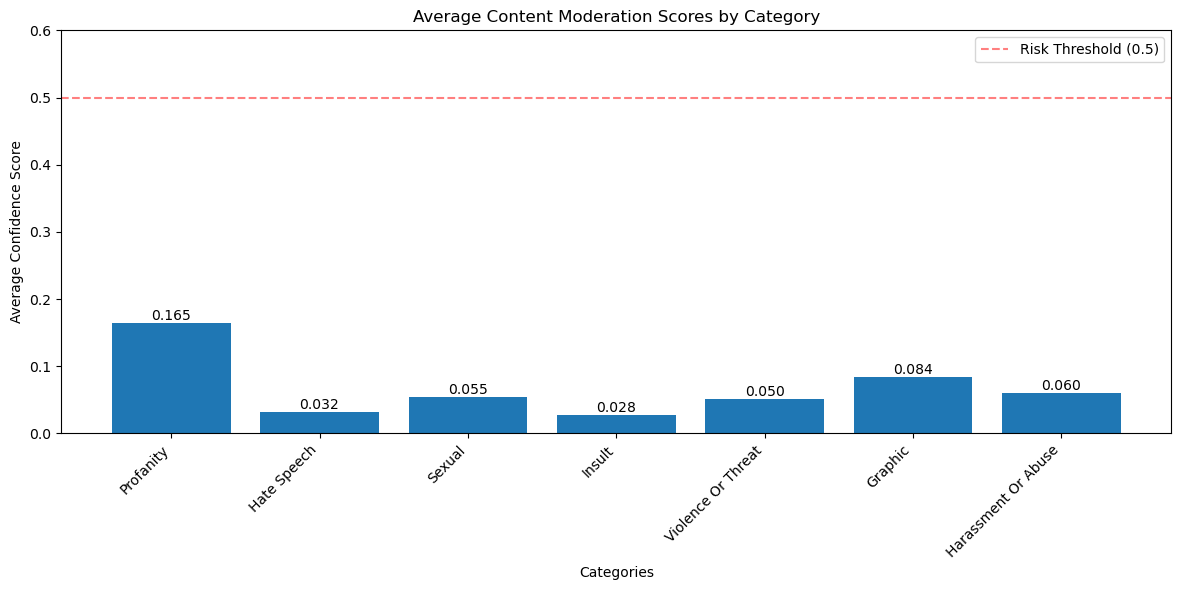

In [19]:
import matplotlib.pyplot as plt

def generate_moderation_summary(json_data):
    moderation_results = json_data.get('audio', {}).get('content_moderation', [])
    
    # Initialize category averages
    category_scores = {
        'profanity': [],
        'hate_speech': [],
        'sexual': [],
        'insult': [],
        'violence_or_threat': [],
        'graphic': [],
        'harassment_or_abuse': []
    }
    
    # Collect all scores for each category
    for segment in moderation_results:
        for category in segment.get('moderation_categories', []):
            category_scores[category['category']].append(category['confidence'])
    
    # Calculate averages and prepare data for plotting
    categories = []
    averages = []
    max_scores = []
    
    for category, scores in category_scores.items():
        if scores:
            avg_score = sum(scores) / len(scores)
            max_score = max(scores)
            categories.append(category.replace('_', ' ').title())
            averages.append(avg_score)
            max_scores.append(max_score)
    
    # Create the visualization
    plt.figure(figsize=(12, 6))
    
    # Create bars
    x = range(len(categories))
    bars = plt.bar(x, averages)
    
    # Customize the plot
    plt.title('Average Content Moderation Scores by Category')
    plt.xlabel('Categories')
    plt.ylabel('Average Confidence Score')
    
    # Rotate x-axis labels for better readability
    plt.xticks(x, categories, rotation=45, ha='right')
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Add a horizontal line at 0.5 to show the threshold
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Risk Threshold (0.5)')
    plt.legend()
    
    # Set y-axis limits to include some padding
    plt.ylim(0, max(max(averages) * 1.2, 0.6))
    
    # Show the plot
    plt.show()

generate_moderation_summary(data)

## Clean Up
Let's delete the sample files that were downloaded locally and that uploaded to S3. 1. Delete the BDA project you created. 2. Delete files you uploaded to S3.

## Summary
In this lab, we use BDA to extract and analyze a sample podcast audio. The BDA output includes audio summary, speaker identification and moderation detections, as specified in the BDA project configuration. 